In [2]:
import torchvision.datasets as datasets
# mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [3]:
import torch as th
import syft as sy

hook = sy.TorchHook(th)

In [4]:
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
trusted_agg = sy.VirtualWorker(hook, id = "trusted_agg")

bob.clear_objects()
alice.clear_objects()
trusted_agg.clear_objects()

<VirtualWorker id:trusted_agg #objects:0>

In [5]:
device = th.device("cuda")

In [6]:
import torchvision.transforms as transforms

federated_train_loader = sy.FederatedDataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])).federate((bob, alice)), 
                                                batch_size=64, shuffle=True)

test_loader = th.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True,)

In [7]:
# bob_train_dataset = sy.BaseDataset(train_data[:train_idx], train_labels[:train_idx]).send(bob)
# bob_test_dataset = sy.BaseDataset(test_data[:test_idx], test_labels[:test_idx]).send(bob)

# alice_train_dataset = sy.BaseDataset(train_data[train_idx:], train_labels[train_idx:]).send(alice)
# alice_test_dataset = sy.BaseDataset(test_data[test_idx:], test_labels[test_idx:]).send(alice)


In [8]:
# federated_train_dataset = sy.FederatedDataset([bob_train_dataset, alice_train_dataset])
# federated_test_dataset = sy.FederatedDataset([bob_test_dataset, alice_test_dataset])

# federated_train_dataloader = sy.FederatedDataLoader(federated_train_dataset, shuffle=True, batch_size = 64)
# federated_test_dataloader = sy.FederatedDataLoader(federated_test_dataset, shuffle=True, batch_size = 64)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [10]:
model = Net().to(device)

In [11]:
def train(model, federate_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(federate_train_loader):
        model.send(data.location)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get()
        if batch_idx % 30 == 0:
            loss = loss.get()
            print(f'Train Epoch: {epoch} [{batch_idx*64}/{len(federate_train_loader)*64} ({100. * batch_idx / len(federated_train_loader)}%)] \t Loss: {loss.item()}')

In [12]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction= 'sum').item() #sum up batch loss
            pred = output.argmax(1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01) 
epoch = 10
for epoch in range(1, epoch + 1):
    train(model, federated_train_loader, optimizer, epoch)
    test(model, test_loader)

th.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60032 (0.0%)] 	 Loss: 2.3842861652374268
Train Epoch: 1 [1920/60032 (3.1982942430703623%)] 	 Loss: 2.2972631454467773
Train Epoch: 1 [3840/60032 (6.3965884861407245%)] 	 Loss: 2.2915751934051514
Train Epoch: 1 [5760/60032 (9.594882729211088%)] 	 Loss: 2.2619338035583496
Train Epoch: 1 [7680/60032 (12.793176972281449%)] 	 Loss: 2.220524311065674
Train Epoch: 1 [9600/60032 (15.991471215351812%)] 	 Loss: 2.105748176574707
Train Epoch: 1 [11520/60032 (19.189765458422176%)] 	 Loss: 2.0877764225006104
Train Epoch: 1 [13440/60032 (22.388059701492537%)] 	 Loss: 1.907545804977417
Train Epoch: 1 [15360/60032 (25.586353944562898%)] 	 Loss: 1.7111232280731201
Train Epoch: 1 [17280/60032 (28.784648187633262%)] 	 Loss: 1.509189248085022
Train Epoch: 1 [19200/60032 (31.982942430703623%)] 	 Loss: 1.5387048721313477
Train Epoch: 1 [21120/60032 (35.18123667377399%)] 	 Loss: 1.3840252161026
Train Epoch: 1 [23040/60032 (38.37953091684435%)] 	 Loss: 1.0371626615524292
Train Epoch: 1 [2496

Train Epoch: 4 [17280/60032 (28.784648187633262%)] 	 Loss: 0.3432607650756836
Train Epoch: 4 [19200/60032 (31.982942430703623%)] 	 Loss: 0.2782602608203888
Train Epoch: 4 [21120/60032 (35.18123667377399%)] 	 Loss: 0.3694225251674652
Train Epoch: 4 [23040/60032 (38.37953091684435%)] 	 Loss: 0.3750835955142975
Train Epoch: 4 [24960/60032 (41.57782515991471%)] 	 Loss: 0.37244901061058044
Train Epoch: 4 [26880/60032 (44.776119402985074%)] 	 Loss: 0.286194384098053
Train Epoch: 4 [28800/60032 (47.97441364605544%)] 	 Loss: 0.4524414539337158
Train Epoch: 4 [30720/60032 (51.172707889125796%)] 	 Loss: 0.24584181606769562
Train Epoch: 4 [32640/60032 (54.37100213219616%)] 	 Loss: 0.28444766998291016
Train Epoch: 4 [34560/60032 (57.569296375266525%)] 	 Loss: 0.22051136195659637
Train Epoch: 4 [36480/60032 (60.76759061833689%)] 	 Loss: 0.31226763129234314
Train Epoch: 4 [38400/60032 (63.96588486140725%)] 	 Loss: 0.2974189221858978
Train Epoch: 4 [40320/60032 (67.16417910447761%)] 	 Loss: 0.2401280

Train Epoch: 7 [32640/60032 (54.37100213219616%)] 	 Loss: 0.16506671905517578
Train Epoch: 7 [34560/60032 (57.569296375266525%)] 	 Loss: 0.20389318466186523
Train Epoch: 7 [36480/60032 (60.76759061833689%)] 	 Loss: 0.2014172077178955
Train Epoch: 7 [38400/60032 (63.96588486140725%)] 	 Loss: 0.11400559544563293
Train Epoch: 7 [40320/60032 (67.16417910447761%)] 	 Loss: 0.07432058453559875
Train Epoch: 7 [42240/60032 (70.36247334754798%)] 	 Loss: 0.18154758214950562
Train Epoch: 7 [44160/60032 (73.56076759061834%)] 	 Loss: 0.1419028639793396
Train Epoch: 7 [46080/60032 (76.7590618336887%)] 	 Loss: 0.23125982284545898
Train Epoch: 7 [48000/60032 (79.95735607675905%)] 	 Loss: 0.25147390365600586
Train Epoch: 7 [49920/60032 (83.15565031982942%)] 	 Loss: 0.16979151964187622
Train Epoch: 7 [51840/60032 (86.35394456289978%)] 	 Loss: 0.2923412621021271
Train Epoch: 7 [53760/60032 (89.55223880597015%)] 	 Loss: 0.2673073410987854
Train Epoch: 7 [55680/60032 (92.75053304904051%)] 	 Loss: 0.17633615

Train Epoch: 10 [48000/60032 (79.95735607675905%)] 	 Loss: 0.12986382842063904
Train Epoch: 10 [49920/60032 (83.15565031982942%)] 	 Loss: 0.24955178797245026
Train Epoch: 10 [51840/60032 (86.35394456289978%)] 	 Loss: 0.12508250772953033
Train Epoch: 10 [53760/60032 (89.55223880597015%)] 	 Loss: 0.18662652373313904
Train Epoch: 10 [55680/60032 (92.75053304904051%)] 	 Loss: 0.1405729055404663
Train Epoch: 10 [57600/60032 (95.94882729211088%)] 	 Loss: 0.31665992736816406
Train Epoch: 10 [59520/60032 (99.14712153518124%)] 	 Loss: 0.05486259609460831

Test set: Average loss: 0.0652, Accuracy: 9796/10000 (98%)



Predicted Digit = tensor([[3]], device='cuda:0')


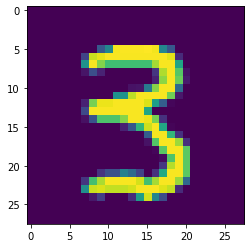

In [36]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images[1]
# img = img.view(1, 784).float()
img = img.view(1,1,28,28).to(device)
with th.no_grad():
    output = model(img)

pred = output.argmax(1, keepdim = True)
print("Predicted Digit =", pred.data)
plt.imshow(img.view(28, 28).cpu().numpy())

In [35]:
# sy.BaseDataset()